# Creating baseline performance for RealWorld Data


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras
import os
from pyseaflux import fCO2_to_pCO2

sys.path.insert(0, '../../src')

from utils import df_to_xarray,read_xarray, custom_rmse

sys.path.insert(0, '../../src/preprocess')
from data_preprocess import preprocess_image_reduced,preprocess_images_nfp, inverse_scale_frame
from data_preprocess import preprocess_images, inverse_scale_image, preprocess_image_reduced

KeyboardInterrupt: 

In [ ]:
dist_map = pd.read_csv("../../src/dist_map.csv",header=None).to_numpy()
dist_map = np.roll(np.fliplr(dist_map),180)
dist_map = np.repeat(dist_map[np.newaxis, :, : ], 480, axis=0)


def pco2_socat_preprocess(arr):
    nans=np.isnan(arr)
    arr[nans] = 0 
    arr[arr>1000]=0
    return arr

def xco2_preprocess(data):
    output = []
    min_xco2 = np.min(data)
    max_xco2=np.max(data)
    new_min=0
    new_max=255
    
    for d in data:
        num = (d-min_xco2)*(new_max-new_min)/(max_xco2-min_xco2)+new_min
        output.append(num)
    return output

In [25]:
dir_name = "../../data/real_world/MERGED-DATA_1x1_mon_198201-202112.nc"
data = xr.open_dataset(f'{dir_name}')

fco2 = data.fco2_ave_unwtd.to_dataframe()
chl = data.chl.to_dataframe()
sss = data.sss.to_dataframe()
sst= data.sst.to_dataframe()
mld = data.mld.to_dataframe()
xco2 = data.atm_pco2_uatm.to_dataframe()

In [78]:
row_data=pd.DataFrame()
row_data["fco2"] = fco2
row_data["chl"] = chl
row_data["sss"] = sss
row_data["sst"] = sst
row_data["mld"] = mld
row_data["xco2"] = xco2

In [79]:
row_data.shape

(31104000, 6)

In [82]:
row_data = row_data.reset_index().set_index('time')
row_data =row_data.dropna()

In [85]:
row_data["pco2"] = fCO2_to_pCO2(row_data.fco2,row_data.sst)

In [88]:
features = ['lon', 'lat','mld','sst','sss','chl','xco2','pco2']
combined=row_data[features]

In [89]:
combined.head()

,lon,lat,mld,sst,sss,chl,xco2,pco2
time,,,,,,,,
1982-01-15,137.5,-0.5,34.367130,29.022418,34.227975,0.213072,331.245001,321.453359
1982-01-15,137.5,0.5,33.478939,29.269918,34.261681,0.130572,331.245001,337.411690
1982-01-15,137.5,1.5,39.543957,29.666697,34.302076,0.126997,331.245001,343.495774
1982-01-15,136.5,2.5,23.772850,29.420000,34.300365,0.133725,331.245001,344.794275
1982-01-15,137.5,2.5,45.244648,29.702498,34.309180,0.128011,331.245001,345.535754


In [90]:
X=combined.iloc[:,:-1]
y=combined.loc[:,'pco2']

In [92]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X=imp.fit_transform(X)

## Training the RF model

In [93]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 73)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())


param_distribs = {
        'n_estimators': randint(low=20, high=50),
        'max_features': randint(low=1, high=6),
    }

forest_reg = RandomForestRegressor(random_state=42, verbose=3,n_jobs=-1,max_depth=10,warm_start= True)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=7, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train, y_train)

final_model =rnd_search.best_estimator_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    7.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  48 out of  48 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]:

building tree 3 of 48
building tree 7 of 48
building tree 10 of 48
building tree 13 of 48
building tree 16 of 48
building tree 19 of 48
building tree 22 of 48
building tree 25 of 48
building tree 29 of 48
building tree 31 of 48
building tree 35 of 48
building tree 38 of 48
building tree 42 of 48
building tree 45 of 48
building tree 1 of 48
building tree 6 of 48
building tree 8 of 48
building tree 14 of 48
building tree 17 of 48
building tree 21 of 48
building tree 25 of 48
building tree 29 of 48
building tree 33 of 48
building tree 37 of 48
building tree 41 of 48
building tree 44 of 48
building tree 48 of 48
building tree 4 of 48
building tree 8 of 48
building tree 11 of 48
building tree 16 of 48
building tree 20 of 48
building tree 24 of 48
building tree 27 of 48
building tree 31 of 48
building tree 33 of 48
building tree 37 of 48
building tree 41 of 48
building tree 45 of 48
building tree 48 of 48
building tree 4 of 48
building tree 8 of 48
building tree 12 of 48
building tree 16 of 

[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  23 out of  23 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


building tree 2 of 48
building tree 9 of 48
building tree 14 of 48
building tree 20 of 48
building tree 26 of 48
building tree 30 of 48
building tree 34 of 48
building tree 37 of 48
building tree 41 of 48
building tree 44 of 48
building tree 48 of 48
building tree 4 of 48
building tree 7 of 48
building tree 12 of 48
building tree 16 of 48
building tree 19 of 48
building tree 23 of 48
building tree 27 of 48
building tree 30 of 48
building tree 34 of 48
building tree 36 of 48
building tree 40 of 48
building tree 43 of 48
building tree 47 of 48
building tree 2 of 48
building tree 5 of 48
building tree 9 of 48
building tree 12 of 48
building tree 15 of 48
building tree 19 of 48
building tree 23 of 48
building tree 26 of 48
building tree 30 of 48
building tree 32 of 48
building tree 36 of 48
building tree 40 of 48
building tree 44 of 48
building tree 47 of 48
building tree 2 of 48
building tree 5 of 48
building tree 9 of 48
building tree 14 of 48
building tree 19 of 48
building tree 23 of 4

[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  23 out of  23 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  23 out of  23 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.8s


building tree 1 of 48
building tree 5 of 48
building tree 11 of 48
building tree 17 of 48
building tree 23 of 48
building tree 28 of 48
building tree 33 of 48
building tree 40 of 48
building tree 47 of 48
building tree 3 of 48
building tree 10 of 48
building tree 11 of 48
building tree 15 of 48
building tree 18 of 48
building tree 22 of 48
building tree 26 of 48
building tree 28 of 48
building tree 32 of 48
building tree 35 of 48
building tree 39 of 48
building tree 42 of 48
building tree 46 of 48
building tree 1 of 48
building tree 6 of 48
building tree 10 of 48
building tree 14 of 48
building tree 18 of 48
building tree 22 of 48
building tree 25 of 48
building tree 29 of 48
building tree 35 of 48
building tree 38 of 48
building tree 42 of 48
building tree 46 of 48
building tree 3 of 48
building tree 7 of 48
building tree 11 of 48
building tree 15 of 48
building tree 18 of 48
building tree 24 of 48
building tree 27 of 48
building tree 31 of 48
building tree 36 of 48
building tree 39 o

[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  41 out of  41 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  41 out of  41 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


building tree 4 of 48
building tree 6 of 48
building tree 8 of 48
building tree 12 of 48
building tree 15 of 48
building tree 18 of 48
building tree 21 of 48
building tree 24 of 48
building tree 27 of 48
building tree 32 of 48
building tree 36 of 48
building tree 39 of 48
building tree 43 of 48
building tree 46 of 48
building tree 2 of 48
building tree 5 of 48
building tree 9 of 48
building tree 13 of 48
building tree 20 of 48
building tree 24 of 48
building tree 31 of 48
building tree 38 of 48
building tree 45 of 48
building tree 3 of 48
building tree 7 of 48
building tree 13 of 48
building tree 17 of 48
building tree 21 of 48
building tree 28 of 48
building tree 34 of 48
building tree 39 of 48
building tree 43 of 48
building tree 1 of 48
building tree 6 of 48
building tree 10 of 48
building tree 13 of 48
building tree 17 of 48
building tree 20 of 48
building tree 22 of 48
building tree 26 of 48
building tree 30 of 48
building tree 33 of 48
building tree 38 of 48
building tree 41 of 4

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  41 out of  41 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  41 out of  41 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using

building tree 1 of 40building tree 2 of 40
building tree 3 of 40

building tree 4 of 40
building tree 5 of 40
building tree 6 of 40
building tree 7 of 40
building tree 8 of 40
building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.6s


building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    6.0s finished


## Result

In [111]:
y_pred=final_model.predict(X_test)
test_mse=mean_squared_error(y_test, y_pred,squared=True)
np.sqrt(test_mse)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.1s finished


19.31420807586487

In [ ]:
y_pred=final_model.predict(X)
final_test_rmse=np.sqrt(mean_squared_error(y, y_pred,squared=True))
error=y-y_pred

final_test_rmse

In [ ]:
std

## Graph

In [114]:
row_data=pd.DataFrame()
row_data["chl"] = chl
row_data["sss"] = sss
row_data["sst"] = sst
row_data["mld"] = mld
row_data["xco2"] = xco2

In [115]:
row_data = row_data.reset_index().set_index('time')
row_data =row_data.dropna()

In [116]:
X=imp.fit_transform(row_data)

In [117]:
pred_full=final_model.predict(X)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    3.3s finished


(array([4.250000e+02, 3.150000e+02, 5.750000e+02, 1.822000e+03,
        1.356000e+03, 8.650000e+02, 7.450000e+02, 4.940000e+02,
        4.400000e+03, 1.121000e+03, 2.081000e+03, 1.089900e+04,
        2.387800e+04, 1.047400e+04, 6.008000e+03, 3.893000e+03,
        5.509000e+03, 4.500000e+05, 4.561263e+06, 5.403160e+06,
        2.766850e+05, 1.732850e+05, 1.142580e+05, 3.799250e+05,
        1.186881e+06, 9.859090e+05, 5.193580e+05, 8.086300e+04,
        5.072700e+04, 4.306000e+03]),
 array([185.19253183, 193.64180739, 202.09108296, 210.54035853,
        218.98963409, 227.43890966, 235.88818523, 244.3374608 ,
        252.78673636, 261.23601193, 269.6852875 , 278.13456306,
        286.58383863, 295.0331142 , 303.48238977, 311.93166533,
        320.3809409 , 328.83021647, 337.27949203, 345.7287676 ,
        354.17804317, 362.62731873, 371.0765943 , 379.52586987,
        387.97514544, 396.424421  , 404.87369657, 413.32297214,
        421.7722477 , 430.22152327, 438.67079884]),
 <BarContainer

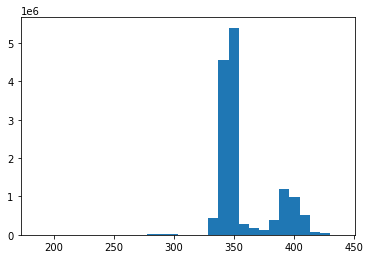

In [118]:
plt.hist(pred_full,bins=30)

In [148]:
np.std(pred_full)

23.180884804458476

In [119]:
row_data["pred"]= pred_full

In [121]:
row_data=row_data.reset_index()

In [122]:
row_data=row_data.set_index(["time","lat","lon"])
row_data.head()

chl        sss       sst        mld        xco2  \
time       lat   lon                                                           
1982-01-15 -77.5 168.5  1.440366  34.247613 -0.404978  21.273363  331.245001   
                 169.5  1.479136  34.266003 -0.241831  41.219284  331.245001   
                 181.5  2.355936  34.247021  0.012358  27.736862  331.245001   
                 185.5  2.704725  34.175253  0.225575  28.411743  331.245001   
                 186.5  2.905759  34.155863  0.124446  33.557903  331.245001   

                             pred  
time       lat   lon               
1982-01-15 -77.5 168.5  341.27857  
                 169.5  341.27857  
                 181.5  341.27857  
                 185.5  341.27857  
                 186.5  341.27857

In [123]:
pred_df = row_data["pred"]

pred_xarray = pred_df.to_xarray()

In [ ]:
import matplotlib.colors as mcolors
import imageio

norm = mcolors.Normalize(vmin=0, vmax = 750)
filenames = []

for i in range(480):
    figure, axis = plt.subplots(1, 1,figsize=(18, 10))
    img = pred_xarray[i].plot(cmap = "coolwarm",norm=norm)
    axis=img
    
    filename = f'{i}.png'
    filenames.append(filename)
    plt.savefig(filename)
    plt.close
    if i%40 == 0:
        print(str(i)+"th photo generated")
    
with imageio.get_writer('../../assets/rf_real.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

for filename in set(filenames):
    os.remove(filename)